In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('darkgrid')

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

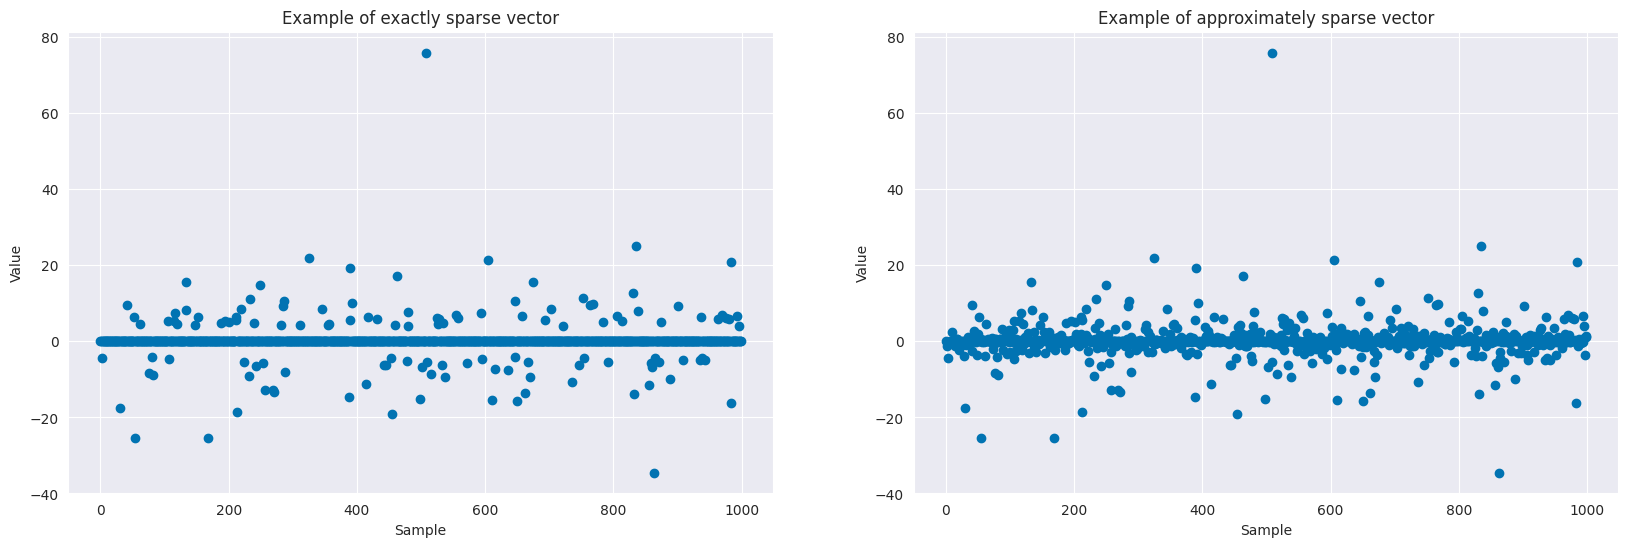

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

__Answer__

An exactly sparse signal has a support of low cardinality compared to the number of samples. That is, a large number of samples are exactly zero. On the other hand, an approximately sparse signal there will exist a margin on what is considered as a zero sample.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

__Answer__

We can see that the shape of the obtained figure resembles a star, and we can see many values close to (0,0), since the sources are sparse. In addition, the branches of the star correspond to the values of the form (0,x) and (y,0) for the same reason.

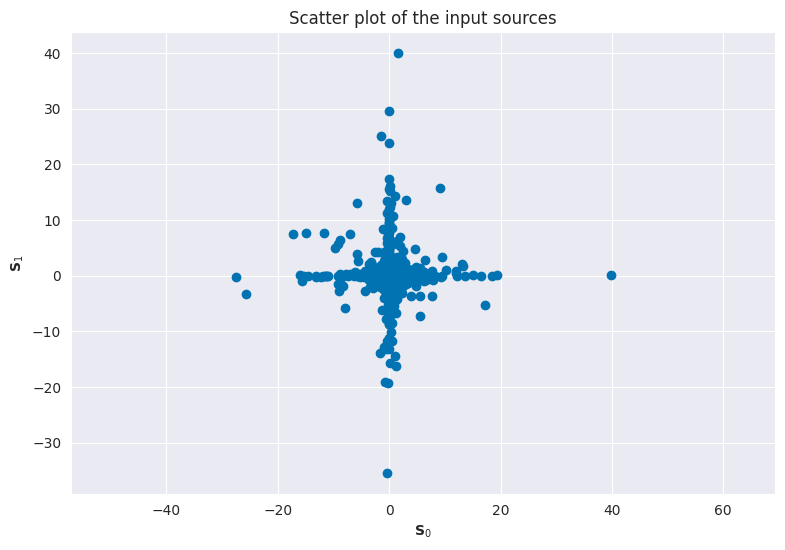

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation


S = np.random.randn(n,t)**power # TO CHANGE

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ? 

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

__Answer__

We can see that the directions of the lines correspond to the first two principal axes given by the mixing matrix we obtained. When we increase the noise_values, the signals become less sparse, which means that the mixture will result in a different shape. In addition, when we increase the powers, the signals become more sparse, which means that the influence of the noise is less important.

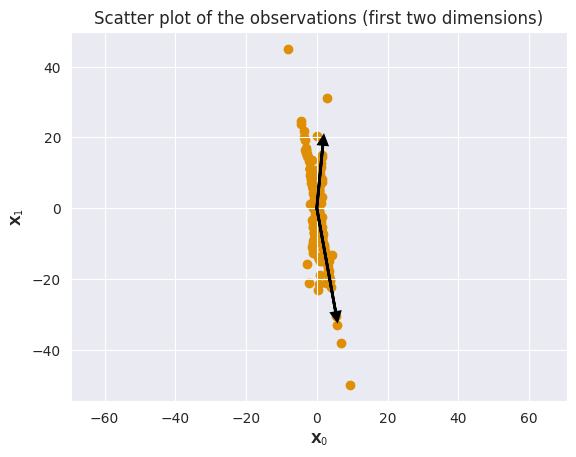

In [5]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

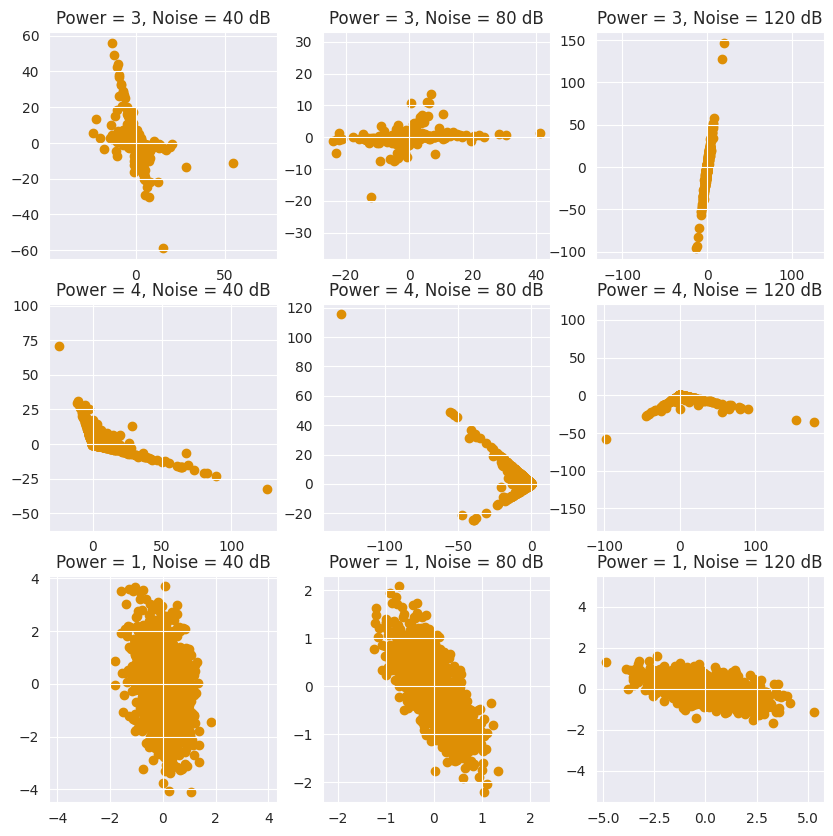

In [6]:
ax, fig = plt.subplots(3, 3, figsize=(10, 10))
for i in [1,3,4]:
    for j in [40, 80, 120]:
        powers = i
        noise_level = j
        S = np.random.randn(n,t)**powers
        A = np.random.randn(m,n)
        X = A@S
        if noise_level < 120:
            N = np.random.randn(m,t)
            N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
            X = X + N
            
        fig[i//2-1, j//40-1].plot(X[0,:], X[1,:], 'C1o', zorder=0)
        fig[i//2-1, j//40-1].set_title('Power = {}, Noise = {} dB'.format(i, j))
        #fig[i//2-1, j//40-1].set_xlabel("$\mathbf{X}_0$")
        #fig[i//2-1, j//40-1].set_ylabel("$\mathbf{X}_1$")
        fig[i//2-1, j//40-1].axis('equal');
        



**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

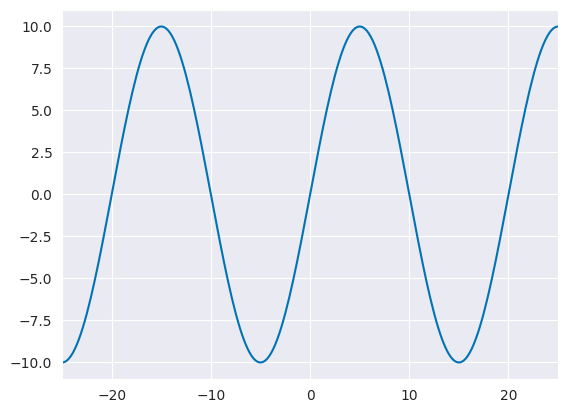

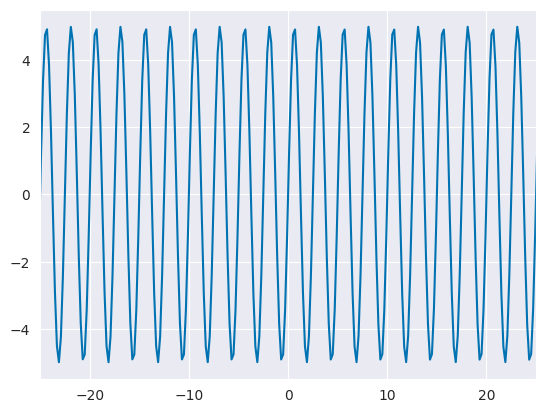

In [7]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

__Answer__

The DCT enables us to project sparse signals in another space, which makes it easier to identify the frequencies that compose them. We can see peaks at the frequencies of the signal, with a slight shift in relation to the original signal.

Value for frequency 0.05 is 0.06283185307179587
Value for frequency 0.4 is 0.5026548245743669
Value for frequency 0.1 is 0.12566370614359174
Value for frequency 0.8 is 1.0053096491487339
Value for frequency 0.2 is 0.25132741228718347
Value for frequency 1.6 is 2.0106192982974678
Value for frequency 0.3 is 0.37699111843077515
Value for frequency 2.4 is 3.015928947446201


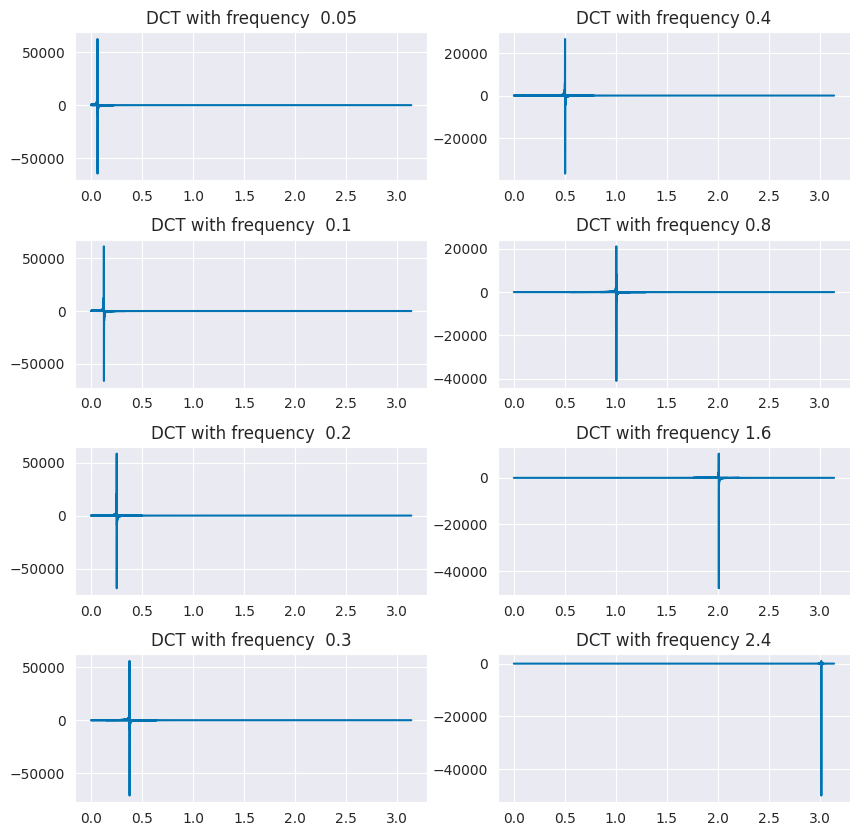

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
for j,i in enumerate(zip ([0.05, 0.1, 0.2, 0.3], [0.4, 0.8, 1.6, 2.4])):
    S[0,:] = 10*np.sin(2*np.pi*i[0]*x_abs)
    S[1,:] = 5*np.sin(2*np.pi*i[1]*x_abs)

    # Transformation into the DCT domain
    Sf = sff.dct(S)
    p = np.linspace(0,t-1,t)
    x = p * (np.pi/t)

    ax[j, 0].plot(x, Sf[0,:])
    ax[j, 0].set_title('DCT with frequency  ' + str(i[0]))
    ax[j, 1].plot(x, Sf[1,:])
    ax[j, 1].set_title('DCT with frequency ' + str(i[1]))

    #plt.figure(),plt.plot(x,np.abs(Sf[0,:]))
    #plt.figure(),plt.plot(x,np.abs(Sf[1,:]))
#
    print ('Value for frequency ' + str(i[0]) + ' is ' + str((x[np.argmax(Sf[0,:])] + x[np.argmin(Sf[0,:])])/2))
    print ('Value for frequency ' + str(i[1]) + ' is ' + str((x[np.argmax(Sf[1,:])] + x[np.argmin(Sf[1,:])])/2))
#increase vertical space
plt.subplots_adjust(hspace=0.4)

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

__Answer__

As we can see, the DCT makes it possible to project the mixture into a space where we can distinguish the frequencies that compose it, since it is impossible due to the mixture. We can use this characteristic to recover the sources.

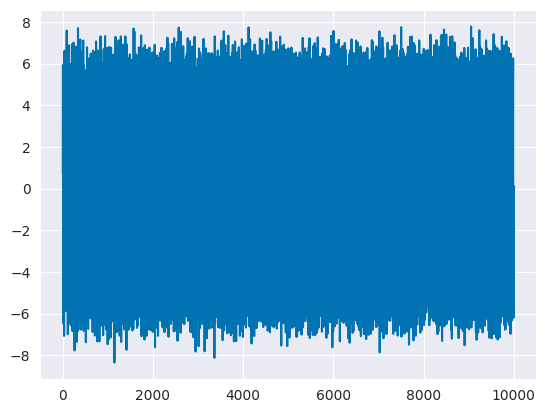

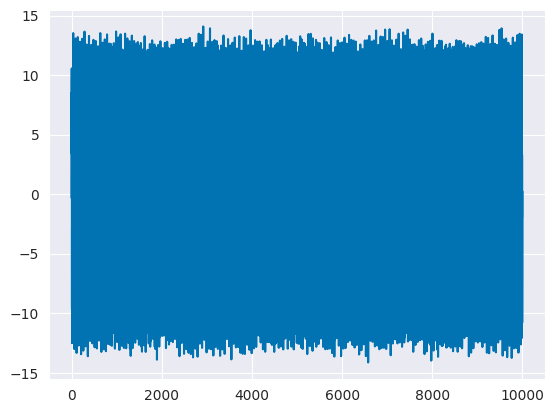

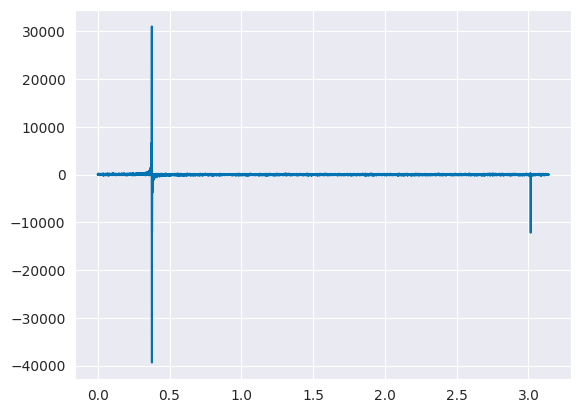

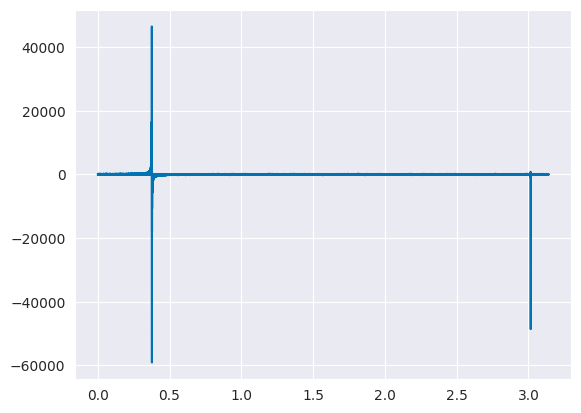

In [9]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

plt.plot(X[0,:])
plt.show()
plt.plot(X[1,:])
plt.show()

Xf = sff.dct(X)
p = np.linspace(0,t-1,t)
x = np.pi/t * p

plt.plot(x,(Xf[0,:]))
plt.show()
plt.plot(x,(Xf[1,:]))
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


__Answer__

We want to minimize $||X - AS||^2 + \lambda ||S||_1$, where the first term corresponds to the likelihood, and the second term ensures the sparsity of the solution. The function is convex and not differentiable everywhere because of the $l_1$ norm.

Compute the gradient along the S variable of the data-fidelity term.

__Answer__

The gradient can be computed as follows:

$$\nabla_S ||X - AS||^2 = -2A^T(X - AS)$$

Recall what the proximal operator of the l1-norm is.

__Answer__

The proximal operator of the l1-norm is the soft thresholding operator, which is defined as follows:

$1)s_i - \lambda$ ,if $s_i \geq \lambda$

$2)0$ ,if $|s_i| < \lambda$

$3)s_i + \lambda$ ,if $s_i \leq -\lambda$

In [10]:
# TO DO: implement the proximal operator of the l1-norm in the above function:

def prox_l1(S_est,thrd):
    S_est[S_est>thrd] -=  thrd
    S_est[S_est<-thrd] += thrd
    S_est[abs(S_est)<=thrd] = 0
    
    return S_est



Explain the main idea of the ISTA algorithm. Then, implement it.

__Answer__

The ISTA algorithm is a method that enables us to minimize the cost function with a gradient descent on the likelihood term and then we minimize it by ensuring the sparsity.

In [11]:
def ISTA(X, A=np.eye(2), n=2, lamb=0, nbIt=100):
    gamma = 0.9 / np.linalg.norm(A.T @ A)
    
    S_est = np.zeros((n, X.shape[1]))
    
    for _ in range(nbIt):
        S_est = prox_l1(S_est + gamma * A.T @ (X - A @ S_est), gamma * lamb)

    return S_est


It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

__Answer__

High values of $\lambda$ generate a high sparsity, which leads to values close to 0. However, if we use low values, the sparsity constraint is not strong enough and we have more noise in the result. With good values of $\lambda$ we can find sparse sources in the DCT domain with peaks at the right frequencies. Values lower than 50, for example, produces noisy results.

In [12]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

__Answer__

We can see that the sources are sparse in the DCT domain, since we have peaks at the frequencies of the original signals.

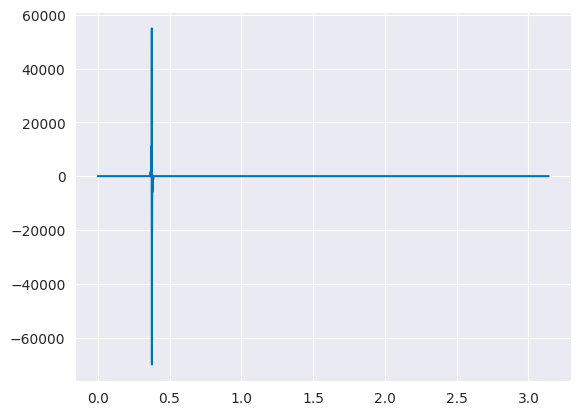

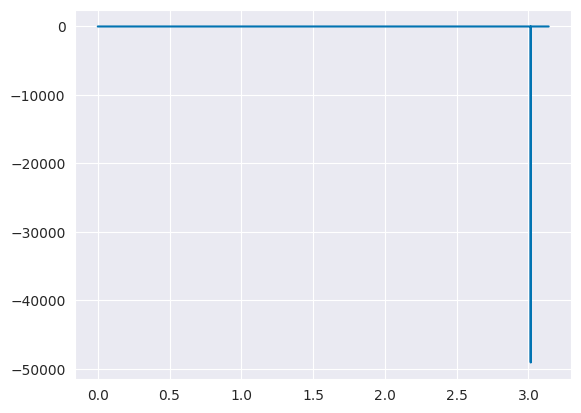

In [13]:
plt.plot(x,S_estf[0,:])
plt.show()
plt.plot(x,S_estf[1,:])
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

__Answer__

We can see that the signal is bad reconstructed, specially on the edges, which is one of the caveats of the DCT algorithm. However, we the center of the signal is better reconstructed.

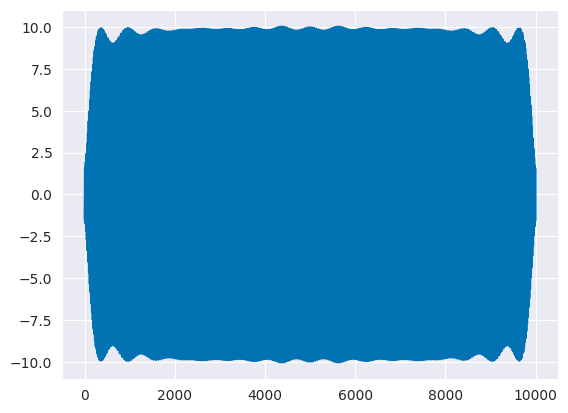

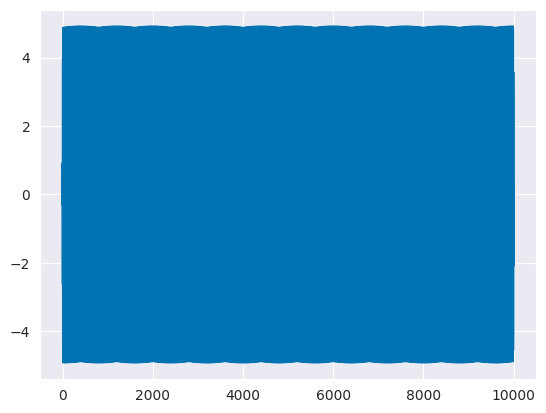

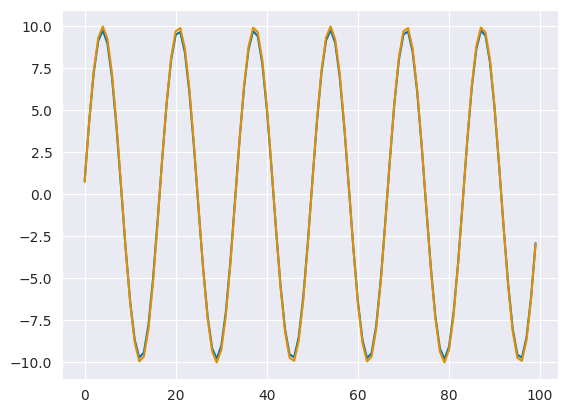

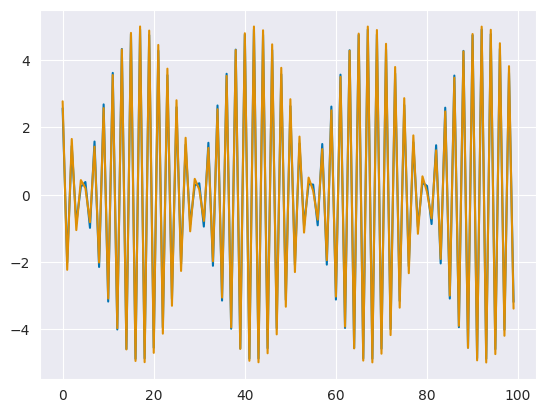

In [14]:
S_tdomain = sff.idct(S_estf)/(10000*2)


plt.plot(S_tdomain[0,:])
plt.show()
plt.plot(S_tdomain[1,:])
plt.show()
c = 50


plt.plot(S_tdomain[0,2000-c:2000+c])
plt.plot(S[0,2000-c:2000+c])
plt.show()
plt.plot(S_tdomain[1,2000-c:2000+c])
plt.plot(S[1,2000-c:2000+c])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




__Answer__

The cost function we want to minimize is given by:

$$
\frac{1}{2}||X-AS||^2 + \lambda ||S||_1 + \mathbb{1}A
$$

In which we have the likelihood term and the sparsity constraint on A (to prevent degenerate solutions, which is smooth). The function is not convex, because of the second term.

Recall what the gradient of the data fidelity term over A is.

__Answer__

The gradient of the data fidelity term over A is given by:

$$ \nabla_A ( ||X - AS||^2) = -(X-AS)S^T $$

Compte the proximal operator of the oblique constraint. Implement it.

In [15]:
def prox_oblique(A):
    for i in range(A.shape[1]):
        A[:,i] = A[:,i]/np.linalg.norm(A[:,i])
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [27]:
def PALM(X, n=2, lamb=0, nbIt=100):
    A_est = np.random.rand(X.shape[0], n)
    S_est = np.random.rand(n, X.shape[1])

    for _ in range(nbIt):
        gamma = 0.9 / np.linalg.norm(A_est @ (A_est.T))
        eta = 0.9 / np.linalg.norm(S_est @ (S_est.T))

        S_est = prox_l1(S_est + gamma * A_est.T @ (X - A_est @ S_est), lamb)
        A_est = prox_oblique(A_est + eta * (X - A_est @ S_est) @ S_est.T)

    return A_est, S_est


Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

__Answer__

We can see that the separation is relatively good, since the true and estimated A matrices are very close.

In [35]:
A_est, S_est = PALM(Xf,n=2,lamb=5000,nbIt = 100)

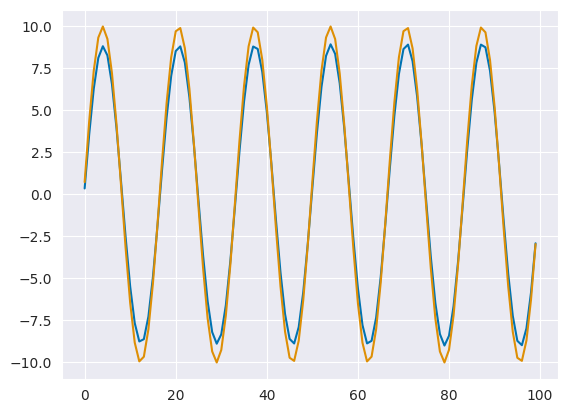

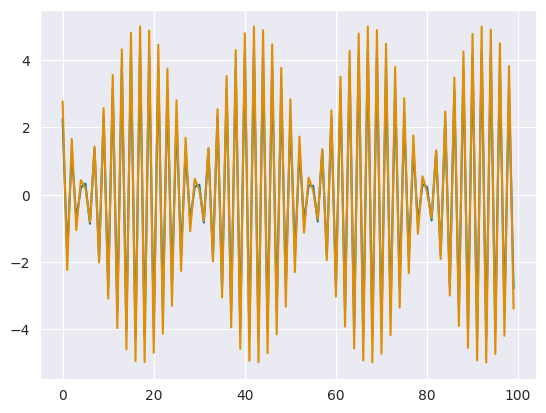

In [36]:
S_tdomain = sff.idct(S_est)
S_tdomain = S_tdomain/np.max(S_tdomain) * np.max(S)

c = 50
plt.plot(S_tdomain[0,2000-c:2000+c])
plt.plot(S[0,2000-c:2000+c])
plt.show()
plt.plot(S_tdomain[1,2000-c:2000+c])
plt.plot(S[1,2000-c:2000+c])
plt.show()

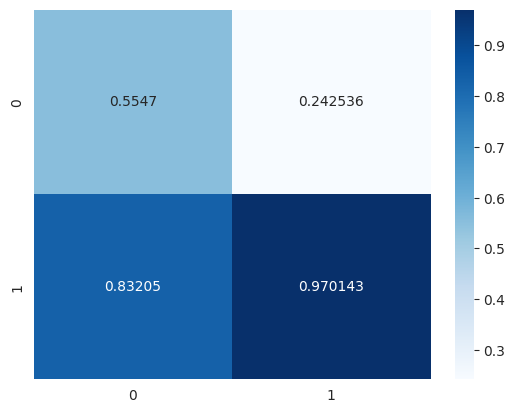

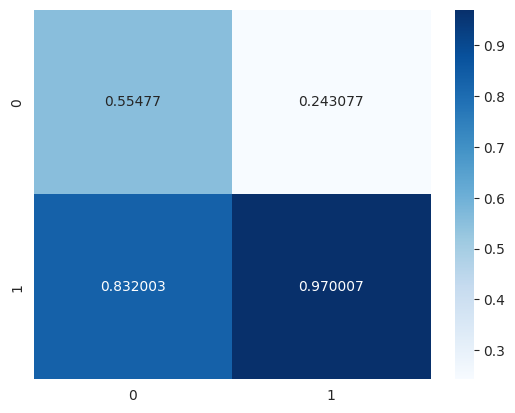

In [38]:
sns.heatmap(A, annot=True, cmap='Blues', fmt='g')
plt.show()
sns.heatmap(A_est, annot=True, cmap='Blues', fmt='g')
plt.show()